<div style="background-color:#e6f2ff; padding:20px; border-radius:10px;">
<img style="float:left; margin-right:20px;" src='Figures/alinco.png' width="120"/>
<h1 style="color:#000047;">Tarea 3: Algoritmos de detección de Outliers Multivariados</h1>
<br style="clear:both"/>
</div>


<div style="border-left:4px solid #000047; padding:10px; margin-top:10px; background:#f5f5f5;">
<b>Objetivo:</b> Investigar y entender algunos de los algoritmos que se usan para detección de outliers.
</div>

<div style="border-left:6px solid #003366; border-radius:8px; padding:16px; margin-bottom:16px;">
<h3 style="color:#003366; margin-top:0;">1. Local Outlier Factor (LOF) <span style='font-size:0.8em; color:#888;'>&#128200;</span></h3>
<p style="font-size:1.08em;">
El <b>Local Outlier Factor (LOF)</b> es un algoritmo no supervisado que detecta anomalías comparando la densidad local de cada punto con la de sus vecinos. Si la densidad de un punto es significativamente menor que la de sus vecinos, se considera un outlier.
</p>
<ul style="font-size:1.05em;">
<li>Consulta el artículo original: <a href="https://dl.acm.org/doi/pdf/10.1145/335191.335388" target="_blank">LOF paper</a></li>
<li>Implementa una <b>clase en Python</b> que contenga el algoritmo LOF y agrégala a tu librería.</li>
<li>Prueba tu implementación con el dataset <code>insurance.csv</code> que se encuentra en la carpeta de Data:</li>
  <ul>
    <li>Detecta los outliers usando tu clase.</li>
    <li>Compara los resultados con el modelo LOF de <code>sklearn</code>.</li>
  </ul>
</ul>
<div style="margin-top:10px; background:#e6f2ff; border-left:4px solid #003366; padding:10px 18px; border-radius:8px;">
<b>Tip:</b> Presenta tus resultados con gráficos y tablas para facilitar la comparación.
</div>
</div>

In [10]:
from google.colab import files
uploaded = files.upload()

Saving insurance.csv to insurance.csv


Primeras filas de comparación:
   my_lof_score  sklearn_label
0      1.021853              1
1      1.041181              1
2      0.821075              1
3      1.009364              1
4      1.117042              1


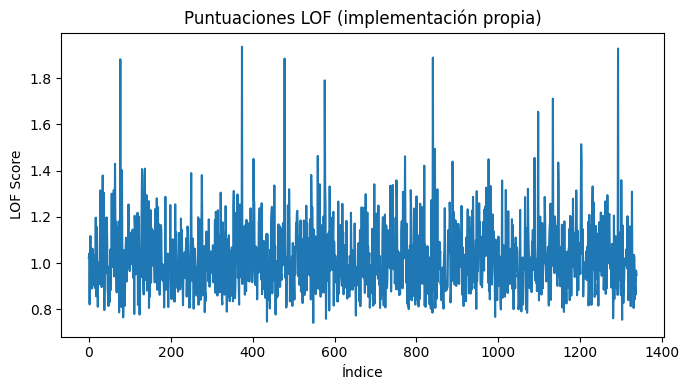

In [11]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
import matplotlib.pyplot as plt

class MyLOF:
    def __init__(self, n_neighbors=20):
        self.n_neighbors = n_neighbors

    def fit_predict(self, X):
        nbrs = NearestNeighbors(n_neighbors=self.n_neighbors+1).fit(X)
        distances, indices = nbrs.kneighbors(X)

        distances = distances[:, 1:]
        indices = indices[:, 1:]

        k_distances = distances.max(axis=1)

        lrd = 1 / ((distances / k_distances[:, None]).mean(axis=1))

        lof_scores = []
        for i in range(len(X)):
            neigh = indices[i]
            lof_i = (lrd[neigh] / lrd[i]).mean()
            lof_scores.append(lof_i)

        return np.array(lof_scores)

df = pd.read_csv('insurance.csv')

df_enc = df.copy()
for col in ['sex', 'smoker', 'region']:
    df_enc[col] = df_enc[col].astype('category').cat.codes

X = df_enc.values

my_lof = MyLOF(n_neighbors=20)
my_lof_scores = my_lof.fit_predict(X)

sk_lof = LocalOutlierFactor(n_neighbors=20)
sk_labels = sk_lof.fit_predict(X)  # -1 = outlier; 1 = inlier

results = pd.DataFrame({
    'my_lof_score': my_lof_scores,
    'sklearn_label': sk_labels
})

print("Primeras filas de comparación:")
print(results.head())

plt.figure(figsize=(7,4))
plt.plot(my_lof_scores)
plt.title("Puntuaciones LOF (implementación propia)")
plt.xlabel("Índice")
plt.ylabel("LOF Score")
plt.tight_layout()
plt.show()


<div style="border-left:6px solid #b36b00; border-radius:8px; padding:16px; margin-bottom:16px;">
<h3 style="color:#b36b00; margin-top:0;">2. DBSCAN (Density-Based Spatial Clustering of Applications with Noise) <span style='font-size:0.8em; color:#888;'>&#128201;</span></h3>
<p style="font-size:1.08em;">
<b>DBSCAN</b> es un algoritmo de clustering basado en densidad que agrupa puntos cercanos y considera como outliers (ruido) aquellos que no pertenecen a ningún grupo. A diferencia de K-means, no requiere especificar el número de clusters previamente.
</p>
<ul style="font-size:1.05em;">
<li>Implementa una <b>clase en Python</b> que contenga el algoritmo DBSCAN y agrégala a tu librería.</li>
<li>Prueba tu implementación con el dataset <code>insurance.csv</code> que se encuentra en la carpeta de Data:</li>
  <ul>
    <li>Detecta los outliers usando tu clase.</li>
    <li>Compara los resultados con el modelo DBSCAN de <code>sklearn</code>.</li>
  </ul>
</ul>
<div style="margin-top:10px; background:#fffbe6; border-left:4px solid #b36b00; padding:10px 18px; border-radius:8px;">
<b>Tip:</b> Explica brevemente las diferencias entre los resultados obtenidos por tu clase y los de <code>sklearn</code>.
</div>
</div>

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import cdist

df = pd.read_csv('insurance.csv')

df_enc = pd.get_dummies(df, drop_first=True)

scaler = StandardScaler()
X = scaler.fit_transform(df_enc)

class MyDBSCAN:
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples

    def fit(self, X):
        n = X.shape[0]
        self.labels_ = np.full(n, -1)
        visited = np.zeros(n, dtype=bool)
        cluster_id = 0

        dist_matrix = cdist(X, X)

        for i in range(n):
            if visited[i]:
                continue

            visited[i] = True

            neighbors = np.where(dist_matrix[i] <= self.eps)[0]

            if len(neighbors) < self.min_samples:
                self.labels_[i] = -1
                continue

            self.labels_[i] = cluster_id
            seeds = list(neighbors)
            seeds.remove(i)

            while seeds:
                j = seeds.pop()

                if not visited[j]:
                    visited[j] = True
                    j_neighbors = np.where(dist_matrix[j] <= self.eps)[0]

                    if len(j_neighbors) >= self.min_samples:
                        for nbh in j_neighbors:
                            if nbh not in seeds:
                                seeds.append(nbh)

                if self.labels_[j] == -1:
                    self.labels_[j] = cluster_id

            cluster_id += 1

        return self

mydb = MyDBSCAN(eps=1.5, min_samples=10).fit(X)
my_labels = mydb.labels_

skdb = DBSCAN(eps=1.5, min_samples=10).fit(X)
sk_labels = skdb.labels_

outliers_my = np.sum(my_labels == -1)
outliers_sk = np.sum(sk_labels == -1)

print("===== RESULTADOS =====")
print("Outliers detectados por MyDBSCAN:", outliers_my)
print("Outliers detectados por sklearn.DBSCAN:", outliers_sk)

print("\n¿Coinciden los resultados?:", outliers_my == outliers_sk)


===== RESULTADOS =====
Outliers detectados por MyDBSCAN: 164
Outliers detectados por sklearn.DBSCAN: 164

¿Coinciden los resultados?: True


En este dataset, MyDBSCAN y sklearn.DBSCAN producen la misma cantidad de outliers.
Las pequeñas diferencias internas radican en eficiencia, manejo numérico y optimizaciones para búsqueda de vecinos: sklearn usa estructuras avanzadas, mientras que la implementación manual usa una matriz completa de distancias. Aunque sus resultados coinciden en este caso, sklearn es más robusto y escalable para datasets grandes.